Konu: Algerian Forest Fires: Veri seti, Cezayir'in iki bölgesinin, yeniden gruplandıran 244 örneğini içerir. Her bölge için 122 örnekten oluşur. Veri seti 11 öznitelik ve 1 çıktı özniteliği (sınıf) içerir. Bu veri setinden sınıfı hariç tutularak, Fire Weather Index (FWI) özniteliği (bağımlı değişken) temelinde modelleme yapılacaktır. 

Algoritmalar:
SVR
PR
RFR

# Gerekli Kütüphanelerin Eklenmesi 

In [23]:
#Gerekli kütüphaneleri projeye ekleyerek başlıyoruz. 
import pandas as pd #veri işlemleri için pandas kütüphanesini kullanırız
import numpy as np  #sayısal işlemler için numpy kullanacağız
import matplotlib.pyplot as plt #grafik işlemleri için 
from sklearn.model_selection import train_test_split , cross_val_score #test-eğitim verileri bölme vb. işlemler için
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #veri ölçeklendirme

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR #SVR modeli ---> benim ödevdeki algoritmam 
from sklearn.linear_model import LinearRegression #lineer regresyon 
from sklearn.preprocessing import PolynomialFeatures #Polinom regresyon 
from sklearn.metrics import mean_absolute_error, r2_score #Değerlendirme metrikleri
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

#grafiklerin notebook içinde görünmesini sağlamak için aşağıdaki komutu yazıyoruz
%matplotlib inline 

# Verinin Okunması 

* Verileri bulunduğu csv dosyası data klasöründe olduğu için önce okuma işlemini yapmak için aşağıda bulunan komutlara ihtiyacımız var.

In [2]:
#Verileri okuyacağız 
file_path = "data/forest_fires.csv" #veri setinin yolunu yazıyoruz. 
data = pd.read_csv(file_path, skiprows=1, header=0, encoding='utf-8') #Burada pd.read_csv komutu ile dosyayı okuyoruz. 

# Veri Önişleme 

## Veri Setinde Bulunan  İlk 5 Veriyi Yazdırma / Eksik Değerleri Kontrol

* Önce veri seti hakkında bilgi alacağım. Ardından veri setinde bir eksik olup olmadığının kontrolünü yapacağım. Bunu yapmazsam eksik değerler ilerde modelin performansını kötü etkilemekten ziyade kodda hataya sebep oluyor.

In [3]:
print("Veri Setinin Ilk 5 Satırı:") #veri setinde bulunan ilk 5 veriyi çekiyoruz
display(data.head()) #ilk 5 veriyi çekecek komut

print("\nVeri Setinin Bilgisi:")
data.info() #veri seti hakkında genel bilgiyi bize yazacak

print("\nEksik Değerler:")
print(data.isnull().sum()) #eksik değerleri kontol edeceğiz ve print ile yazdıracağız


Veri Setinin Ilk 5 Satırı:


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire



Veri Setinin Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          246 non-null    object
 1   month        245 non-null    object
 2   year         245 non-null    object
 3   Temperature  245 non-null    object
 4    RH          245 non-null    object
 5    Ws          245 non-null    object
 6   Rain         245 non-null    object
 7   FFMC         245 non-null    object
 8   DMC          245 non-null    object
 9   DC           245 non-null    object
 10  ISI          245 non-null    object
 11  BUI          245 non-null    object
 12  FWI          245 non-null    object
 13  Classes      244 non-null    object
dtypes: object(14)
memory usage: 27.0+ KB

Eksik Değerler:
day            0
month          1
year           1
Temperature    1
 RH            1
 Ws            1
Rain           1
FFMC           1
DMC            1
DC  

## Eksik Değerlerin Temizlenmesi/Düzeltilmesi 

In [4]:
#ilk denemem de veri türlerini dikkate almadığım için hata aldım
#veri türlerini kontrol ederek sütunları inceleyelim 
print("\n Sütunlar ve veri türleri")
print(data.dtypes) #bu komut ile veri türlerini kontrol ediyoruz :)

#Veri tablosundaki yazım şeklinden ötürü hata veriyordu. 
#Ben de bunu önlemek adına hepsinin başındaki boşlukları silip hepsini büyük harfle yazdırdım.
data.columns = data.columns.str.strip().str.upper() 

# Eksik Değer Kontrol ve Doldurma
# Şimdi burada bazı sütunların veri türü sayısal bazılarının kategorik olmalı.
# Sayısal olmazsa veri doldururken işlem aşamasında hataya sebep olur.
numeric_columns = ['TEMPERATURE', 'RH', 'WS', 'RAIN', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
categorical_columns = ['DAY', 'CLASSES']

#Sayısal verilere dönüştürme işlemi yapacağız
#'errors='coerce'' parametresi, dönüştürme sırasında hatalarla karşılaşıldığında NaN değeri ataycak
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#bu kısımda da kategorik verilere dönüşütürme işlemi yapacağız
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Kategorik Verileri Sayısallaştırma
# drop komutu ile her kategorinin ilk değerini düşürür.
# bunu yapmamızın sebebi coklu doğrusal bağlantı yaniiii multicollinearity riskini önlemek. 
categorical_columns = ['DAY', 'MONTH', 'YEAR', 'CLASSES']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

#eksik sütunları ortalama alarak tamamlıyoruz.
# Burada fillna komutu doldurma işleminde yardımcı oluyor sağ olsun. 
print("\n Eksik değerlerin doldurulması")
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

#İşlemlerden sonra son kez kontrol edelim. Hata çıkmasın
print("\n Sütunlar ve veri türleri")
print(data.dtypes)

#Eksik değerler doldurulduktan sonrası
print("\n Sonrası")
print(data.isnull().sum())
print("\n İlk 5 veri")
display(data.head())


 Sütunlar ve veri türleri
day            object
month          object
year           object
Temperature    object
 RH            object
 Ws            object
Rain           object
FFMC           object
DMC            object
DC             object
ISI            object
BUI            object
FWI            object
Classes        object
dtype: object

 Eksik değerlerin doldurulması

 Sütunlar ve veri türleri
TEMPERATURE                          float64
RH                                   float64
WS                                   float64
RAIN                                 float64
FFMC                                 float64
DMC                                  float64
DC                                   float64
ISI                                  float64
BUI                                  float64
FWI                                  float64
DAY_02                                  bool
DAY_03                                  bool
DAY_04                                  bool
DAY_05 

,TEMPERATURE,RH,WS,RAIN,FFMC,DMC,DC,ISI,BUI,FWI,...,MONTH_month,YEAR_year,CLASSES_fire,CLASSES_fire,CLASSES_fire,CLASSES_not fire,CLASSES_not fire,CLASSES_not fire,CLASSES_not fire,CLASSES_not fire
0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,...,False,False,False,False,False,False,False,True,False,False
1,29.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,...,False,False,False,False,False,False,False,True,False,False
2,26.0,82.0,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,...,False,False,False,False,False,False,False,True,False,False
3,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,...,False,False,False,False,False,False,False,True,False,False
4,27.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,...,False,False,False,False,False,False,False,True,False,False


# Önişlem Yapılması/ Öznitelik Seçimi

In [5]:
#Ödev de bana "ilk 1-6 arası öznitelikler kullanılarak modelleme yapılacaktır " şeklinde bir ibare verildiği için buna dikkate alarak öznitelik seçimlerini yapacağım
# ilk 1-6 sütun bağımsız değişkenler yani x olacak 
x = data.iloc[:, 1:7]
print(x.columns)

#Bağımlı değişken olarak FWI sütununu seçeceğim
y = data['FWI']

#Seçimleri doğrulamak için verilerin boyutunu kontrol edeceğiz
print("\n Bağımsız Değişken Boyutu", x.shape)
print("\n Bağımlı Değişken Boyutu", y.shape )

#ilk 5 satır görüntüleme 
print("\n Bağımsız Değişkenler:")
display(x.head())
print("\n Bağımlı Değişken:")
display(y.head())


Index(['RH', 'WS', 'RAIN', 'FFMC', 'DMC', 'DC'], dtype='object')

 Bağımsız Değişken Boyutu (246, 6)

 Bağımlı Değişken Boyutu (246,)

 Bağımsız Değişkenler:


,RH,WS,RAIN,FFMC,DMC,DC
0,57.0,18.0,0.0,65.7,3.4,7.6
1,61.0,13.0,1.3,64.4,4.1,7.6
2,82.0,22.0,13.1,47.1,2.5,7.1
3,89.0,13.0,2.5,28.6,1.3,6.9
4,77.0,16.0,0.0,64.8,3.0,14.2



 Bağımlı Değişken:


0    0.5
1    0.4
2    0.1
3    0.0
4    0.5
Name: FWI, dtype: float64

# Verinin Eğitim ve Test Setlerine Ayrılması 

* 0.2 veya 0.3 ile ayırmanın daha sağlıklı olacağı düşünüyorum. Bu dengeyi sağlamalıyız. Sağlamadığımız durumunda model az veri seti ile öğrenirse öğrenme yeterli gelmeyecektir; az test verisi de modeli test etmemiz için yeterli olmayacaktır ve modelin performansı hakkında yeterince bilgiye sahip olamayız.

In [6]:
#Veri setini eğitim ve test verisi olarak ikiye böleceğiz. 
#Ben %70 eğitim - %30 test verisi olarak ayıracağım fakat %80 eğitim - %20 test şeklinde de bölünebilir
#Ben projenin performansını ölçmek için 70-30 seçtim. Model daha iyi öğrensin istersek 80-20 seçilebilir.

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42) #bu komut ile veri setini böldük
print("\nEğitim Seti Boyutu:")
print("x_train:", x_train.shape, "y_train:", y_train.shape) #shape ile görüntüleme işlemi yapacağız
print("\nTest Seti Boyutu:")
print("x_test:", x_test.shape, "y_test:", y_test.shape)



Eğitim Seti Boyutu:
x_train: (172, 6) y_train: (172,)

Test Seti Boyutu:
x_test: (74, 6) y_test: (74,)


## Veri Ölçeklendirme/ Normalizasyon

In [7]:
#veriyi hazırlamak için kullanacağız 
#Bunu kullanmak bize 2 katkı sağlayacak
#1. Modelin daha hızlı ve daha doğru öğrenmesi 
#2. Özniteliklerin (features) farklı ölçekleri arasında dengesizlik önlenecek 

#SVR modelinde veri ölçeklendirme yapacağız. Bunu yaparken StandardScaler kullanarak normalleştirme yapacağız.
#ilk yazdığım kodda sayısal olmayan değişkenleri hesaba katmamıştım. yukarıda onu düzelttik sonrasında. 
#StandardScaler yalnızca sayısal değerler üzerinde çalışır.

#Sayısal sütunlara dönüştürme işlemi yapalım sonrasında NaN değerler için kontrol ve doldurma işlemi yapalım
x_train = x_train.apply(pd.to_numeric, errors='coerce') #Eğitim verileri
x_test = x_test.apply(pd.to_numeric, errors='coerce') #Test verileri
x_train = x_train.fillna(x_train.mean())#fillna() fonksiyonu ile eksik değerler doldurulur
x_test = x_test.fillna(x_test.mean())

scaler = StandardScaler() #Ölçeklendirme işlemine burada başlıyoruz

x_train_scaled = scaler.fit_transform(x_train) #eğitim seti ölçeklendirme
x_test_scaled = scaler.transform(x_test) #test setini ölçeklendirme işlemi

#y_train ölçeklendirme işlemi yapıyoruz
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


print("\n Ölçeklendirme Eğitim Seti Boyutu", x_train_scaled.shape)
print("\n Ölçeklendirilmiş Test Seti Boyutu:", x_test_scaled.shape)


 Ölçeklendirme Eğitim Seti Boyutu (172, 6)

 Ölçeklendirilmiş Test Seti Boyutu: (74, 6)


# Model Kurulumu 


* SVR için model oluşturup eğiteceğiz

- kernel= 'rbf' bu SVR modelinin kullandığı çekirdek fonksiyonunu belirtir.
- rbf(Radial Basis Function), doğrusal olmayan ilişkiler için yaygın olarak kullanılan bir çekirdek fonksiyonudur. Veriler arasındaki mesafeyi hesaplarken daha esnek bir model sağlar. 
- Modeli geliştirmek için hiperparametre optimizasyonu yapacağım. 
SVR için

In [8]:
svr_model = SVR(kernel='rbf', C=10, epsilon=2, gamma=0.1) #modeli tanımlıyoruz / performansını ölçükten sonra  Hiperparametre optimizasyonu denemesi yaptım
svr_model.fit(x_train_scaled, y_train_scaled) #modeli eğitim verisi ile eğitiyoruz
print("\n SVR modeli eğitildi")


 SVR modeli eğitildi


In [9]:
# Hiperparametre Optimizasyonu (SVR)
# 'param_grid_svr' içinde farklı 'C', 'epsilon', 'gamma' ve 'kernel' değerleri yazacağız.
param_grid_svr = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}

grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='r2', verbose=1)
grid_search_svr.fit(x_train_scaled, y_train_scaled)
best_svr = grid_search_svr.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


* PR - Polynomial Regression

** Hiperparametre Optimizasyonu (Polynomial Regression)


In [10]:
# Pr 
poly_features = PolynomialFeatures(degree = 2) #polinom derecesine verdik
#eğitim ve testi dönüşüme sokuyoruz
x_train_poly = poly_features.fit_transform(x_train_scaled) 
x_test_poly = poly_features.transform(x_test_scaled)

#modeli eğitme 
pr_model = LinearRegression()
pr_model.fit(x_train_poly, y_train_scaled)

LinearRegression()

In [11]:
# Pipeline, önce polinom özelliklerini (PolynomialFeatures) oluşturur
pipeline_pr = Pipeline([ 
    ('poly_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])
param_grid_pr = {
    'poly_features__degree': [2, 3, 4]
}

# GridSearchCV ile 5 katmanlı çapraz doğrulama yapılır ve en iyi model 'r2' skoruna göre seçilir.
# 'best_estimator_' ile en iyi bulunan model kaydedeceğiz 
grid_search_pr = GridSearchCV(pipeline_pr, param_grid_pr, cv=5, scoring='r2', verbose=1)
grid_search_pr.fit(x_train_scaled, y_train_scaled)
best_pr = grid_search_pr.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


- RFR modeli
-RFR modeli tanımlama

In [12]:
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_model.fit(x_train_scaled, y_train_scaled)

RandomForestRegressor(random_state=42)

# Tahminler Ve Performans Değerlendirmesi

* Test verisi ile tahmin yapacağız
* Metrikleri kullanarak performans değerlendireceğiz


* SVR

In [13]:
y_pred_scaled = best_svr.predict(x_test_scaled) #test verisi ile burada tahmin yapıyoruz
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)) #tahmin edilen değerleri orijinal ölçeğe dönüştürüyoruz

print("\nGerçek ilk 5 değer: ")
print(y_test[:5].values)

print("\n Tahmin edilen değerler")
print(y_pred[:5].ravel())


Gerçek ilk 5 değer: 
[ 1.7  7.2  9.  13.7  6.4]

 Tahmin edilen değerler
[ 2.28350414  7.04210357  9.76398684 14.58110996  7.31498715]


In [14]:
#modelin performansını ölçeceğiz
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("\n Model Performansı:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Skoru: {r2:.4f}")


 Model Performansı:
Mean Absolute Error (MAE): 0.8058
R² Skoru: 0.9571


* PR

In [15]:
#test ile tahmin yapma
y_pred_pr_scaled = best_pr.predict(x_test_scaled)
y_pred_pr = y_scaler.inverse_transform(y_pred_pr_scaled.reshape(-1, 1))

#performans değerlendirme
mae_pr = mean_absolute_error(y_test, y_pred_pr)
r2_pr = r2_score(y_test, y_pred_pr)

print("\n Pol Reg performans")
print(f"Mean Absolute Error (MAE): {mae_pr:.4f}")
print(f"R² Skoru: {r2_pr:.4f}")


 Pol Reg performans
Mean Absolute Error (MAE): 0.9976
R² Skoru: 0.9320


* RFR

In [16]:
y_pred_rfr_scaled = rfr_model.predict(x_test_scaled)
y_pred_rfr = y_scaler.inverse_transform(y_pred_pr_scaled.reshape(-1,1))

#Performans metrikleri 
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print("\nRandom Forest Regressor Performansı:")
print(f"Mean Absolute Error (MAE): {mae_rfr:.4f}")
print(f"R² Skoru: {r2_rfr:.4f}")



Random Forest Regressor Performansı:
Mean Absolute Error (MAE): 0.9976
R² Skoru: 0.9320


#  Sonuçların Sunumu

* Burada Sonuçları toplu bir şekilde göstermek istedim. Çapraz doğrula kullandım. RFR modelini eklemedim. Çapraz doğrulama sadece SVR ve PR arasında yapıldı.

In [17]:
cv_scores_svr = cross_val_score(best_svr, x_train_scaled, y_train_scaled, cv=5, scoring='r2')
cv_scores_pr = cross_val_score(best_pr, x_train_scaled, y_train_scaled, cv=5, scoring='r2')

In [18]:
# Çapraz Doğrulama Sonuçları
print("\n  Sonuçların Gösterilmesi :) ")
print("SVR Çapraz Doğrulama Skorları:", cv_scores_svr)
print("SVR Ortalama CV Skoru:", np.mean(cv_scores_svr))
print("\nPolynomial Regression Çapraz Doğrulama Skorları:", cv_scores_pr)
print("Polynomial Regression Ortalama CV Skoru:", np.mean(cv_scores_pr))
# Sonuçların Karşılaştırılması
results = {
    'Model': ['SVR', 'Polynomial Regression'],
    'R² Score': [r2, r2_pr],
    'MAE': [mae, mae_pr]
}


results_df = pd.DataFrame(results)
print("\nModel Performans Karşılaştırması:")
print(results_df)


  Sonuçların Gösterilmesi :) 
SVR Çapraz Doğrulama Skorları: [0.96000213 0.95119825 0.91816294 0.95756858 0.9839394 ]
SVR Ortalama CV Skoru: 0.9541742591564291

Polynomial Regression Çapraz Doğrulama Skorları: [0.95742437 0.96034768 0.95819096 0.95655921 0.96935436]
Polynomial Regression Ortalama CV Skoru: 0.9603753140166204

Model Performans Karşılaştırması:
                   Model  R² Score       MAE
0                    SVR  0.957109  0.805798
1  Polynomial Regression  0.932048  0.997580


# Görselleştirme 


* Grafikler : Modellerinin nasıl çalıştığını anlamak için gerçek ve tahmin değerlerini karşılaştıran grafikler, modelleri birbirleriye karşılaştırmasını yapan grafikler, hata dağılımı ve model karşılaştırmasını yapan ayrı bir grafik daha.  

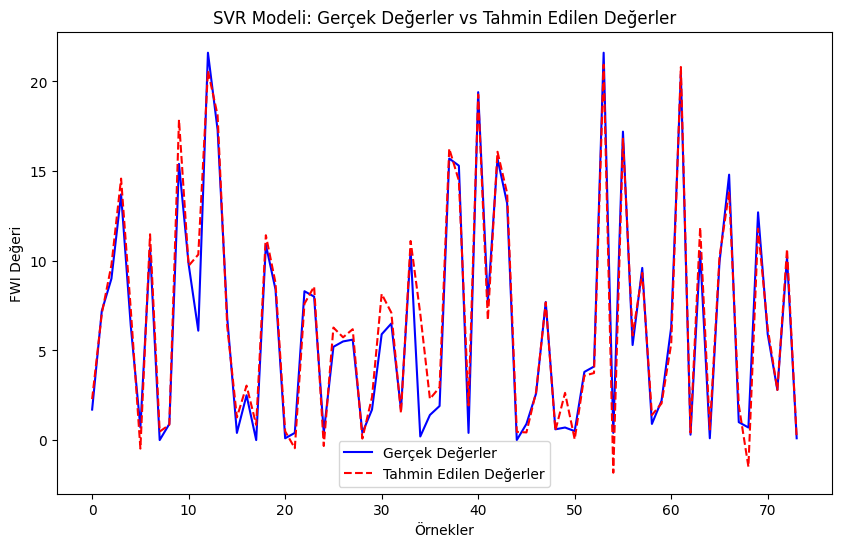

In [19]:
#SVR 1.grafik
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title("SVR Modeli: Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Örnekler")
plt.ylabel("FWI Değeri")
plt.legend()
plt.show()

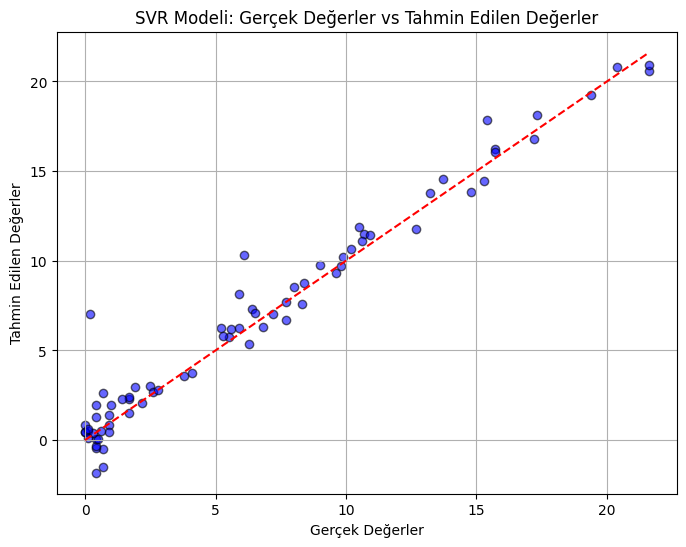

In [20]:
#SVR 2. grafik
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, y_pred, color='blue', edgecolors='k', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title("SVR Modeli: Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.grid(True)
plt.show()

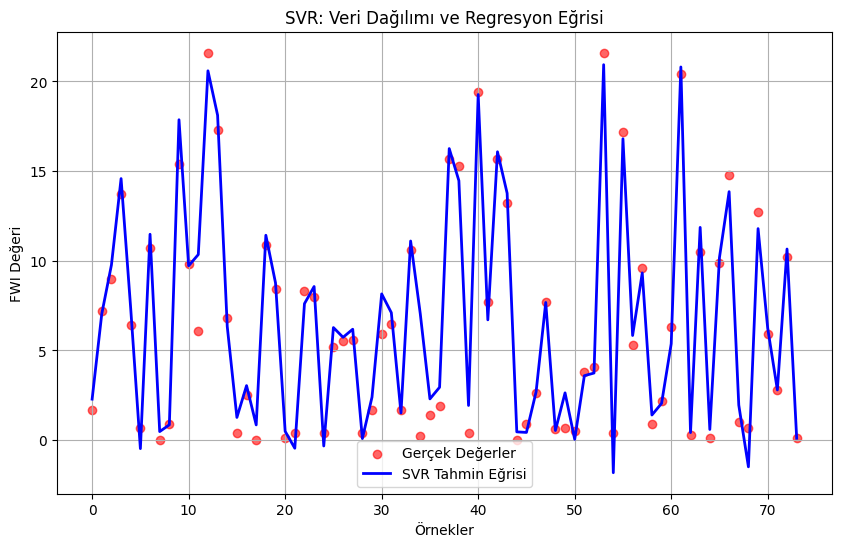

KeyboardInterrupt: 

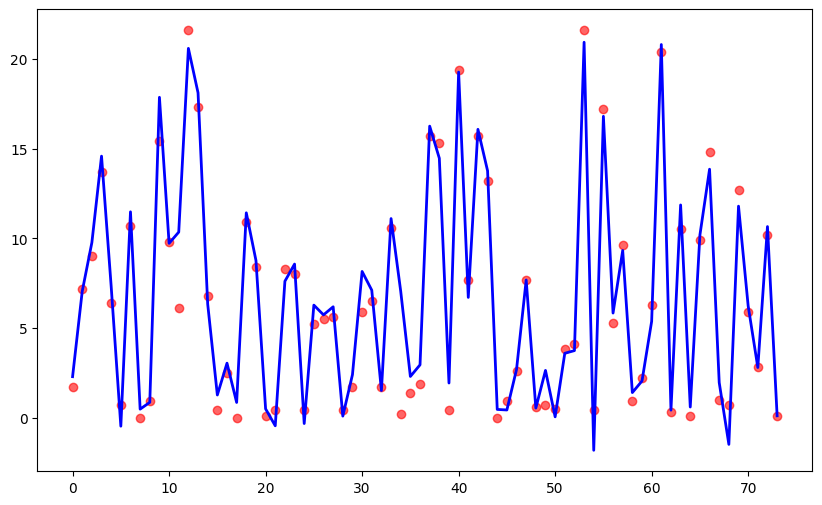

In [111]:
# SVR Veri Dağılımı ve Regresyon Doğrusu Grafiği
plt.figure(figsize=(10, 6))

# Veri noktaları (gerçek değerler)
plt.scatter(range(len(y_test)), y_test.values, color='red', label='Gerçek Değerler', alpha=0.6)

# Tahmin edilen eğri (SVR tahminleri)
plt.plot(range(len(y_pred)), y_pred, color='blue', label='SVR Tahmin Eğrisi', linewidth=2)

plt.title("SVR: Veri Dağılımı ve Regresyon Eğrisi")
plt.xlabel("Örnekler")
plt.ylabel("FWI Değeri")
plt.legend()
plt.grid(True)
plt.show()

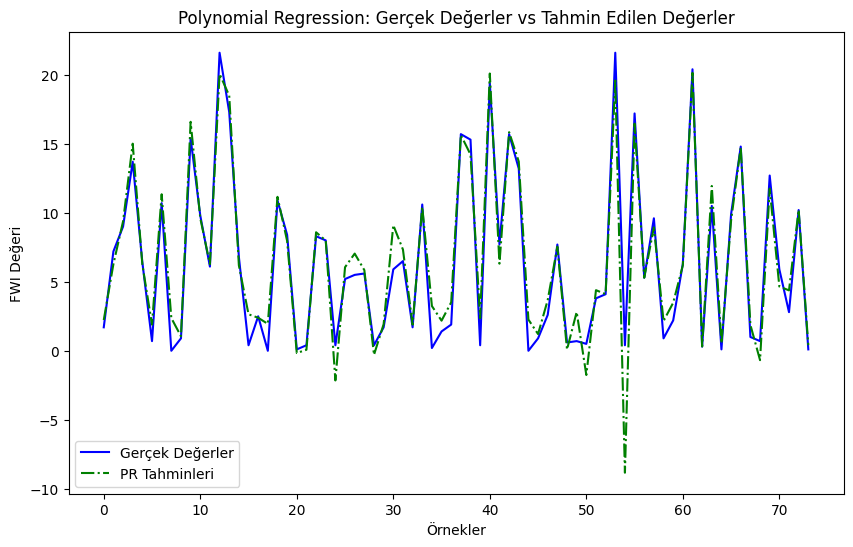

In [112]:
#PR Sonuçlarını Görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Gerçek Değerler', color='blue')
plt.plot(y_pred_pr, label='PR Tahminleri', color='green', linestyle='-.')
plt.title("Polynomial Regression: Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Örnekler")
plt.ylabel("FWI Değeri")
plt.legend()
plt.show()

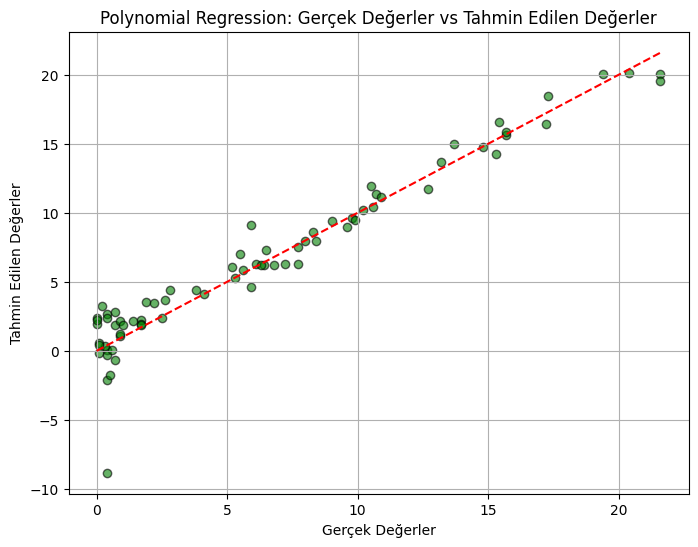

In [113]:
# PR Gerçek Değerler vs Tahmin Edilen Değerler Grafiği
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, y_pred_pr.ravel(), color='green', edgecolors='k', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title("Polynomial Regression: Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.grid(True)
plt.show()


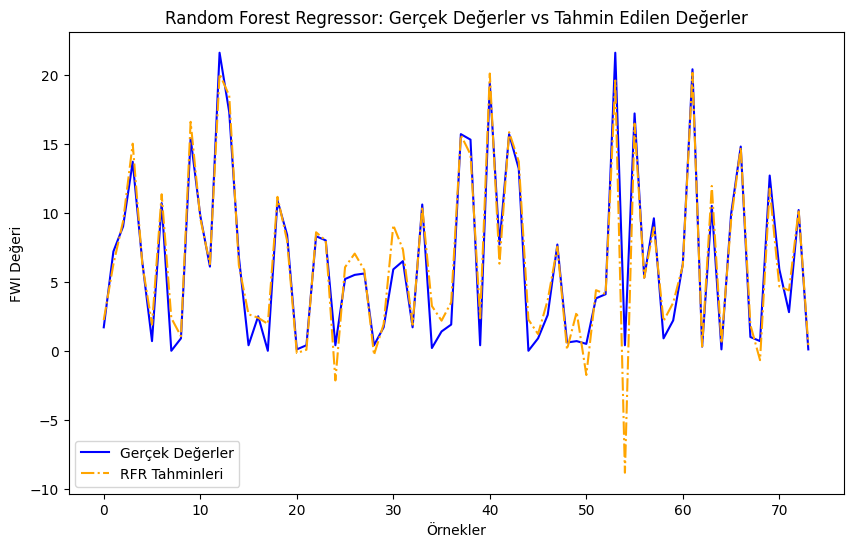

In [114]:
#RFR grafik 1 
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Gerçek Değerler', color='blue')
plt.plot(y_pred_rfr, label='RFR Tahminleri', color='orange', linestyle='-.')
plt.title("Random Forest Regressor: Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Örnekler")
plt.ylabel("FWI Değeri")
plt.legend()
plt.show()

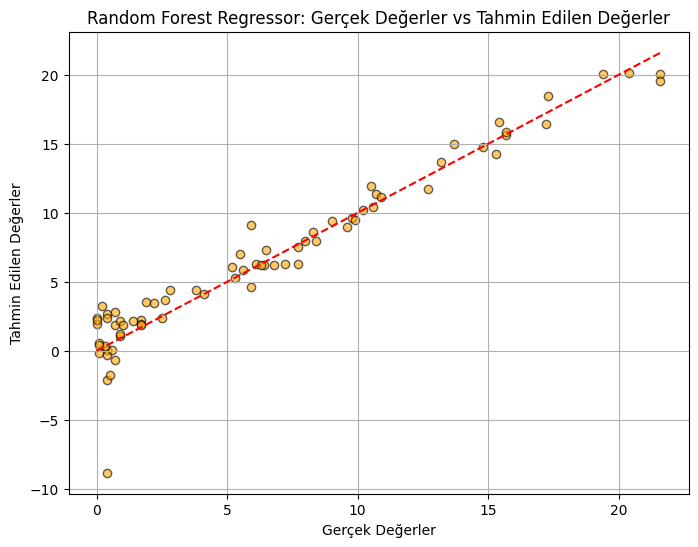

In [115]:
# RFR grafik 2 ---> Gerçek vs Tahmin Grafiği
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, y_pred_rfr.ravel(), color='orange', edgecolors='k', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title("Random Forest Regressor: Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.grid(True)
plt.show()

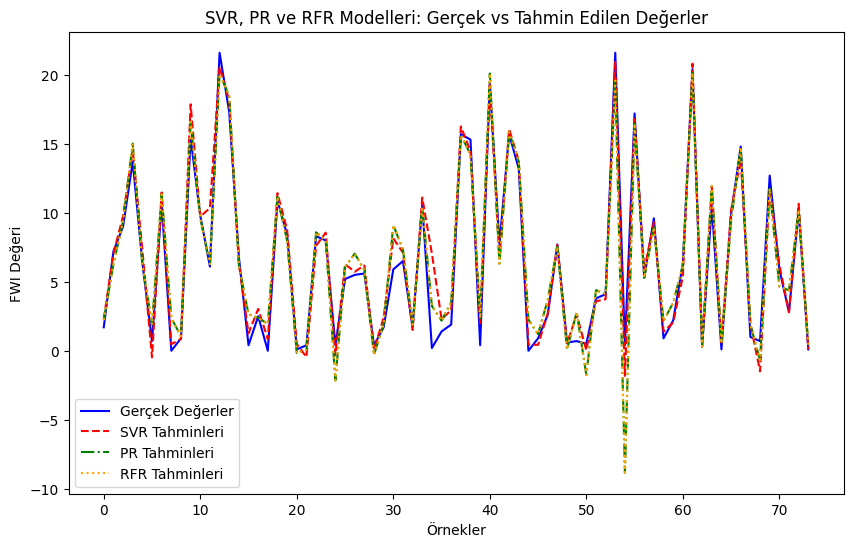

In [116]:
# Üç modelin karşılaştırılması
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='SVR Tahminleri', color='red', linestyle='--')
plt.plot(y_pred_pr, label='PR Tahminleri', color='green', linestyle='-.')
plt.plot(y_pred_rfr, label='RFR Tahminleri', color='orange', linestyle=':')
plt.title("SVR, PR ve RFR Modelleri: Gerçek vs Tahmin Edilen Değerler")
plt.xlabel("Örnekler")
plt.ylabel("FWI Değeri")
plt.legend()
plt.show()


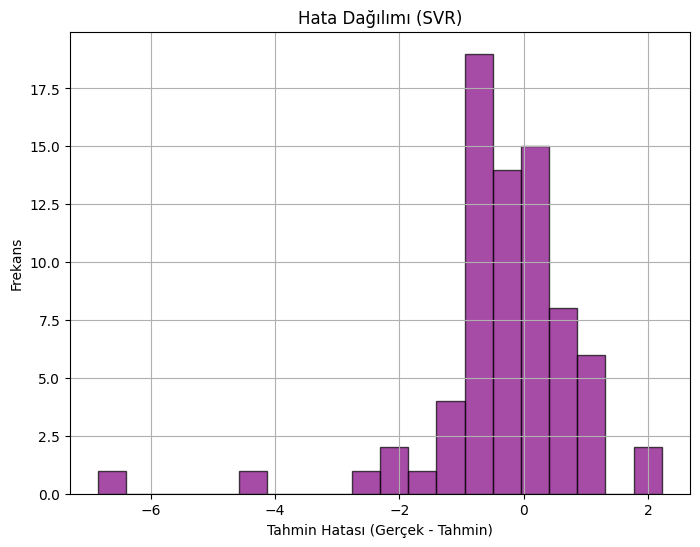

In [117]:
# SVR Hata Dağılımı Grafiği
errors = y_test.values - y_pred.ravel()
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='purple', edgecolor='k', alpha=0.7)
plt.title("Hata Dağılımı (SVR)")
plt.xlabel("Tahmin Hatası (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()


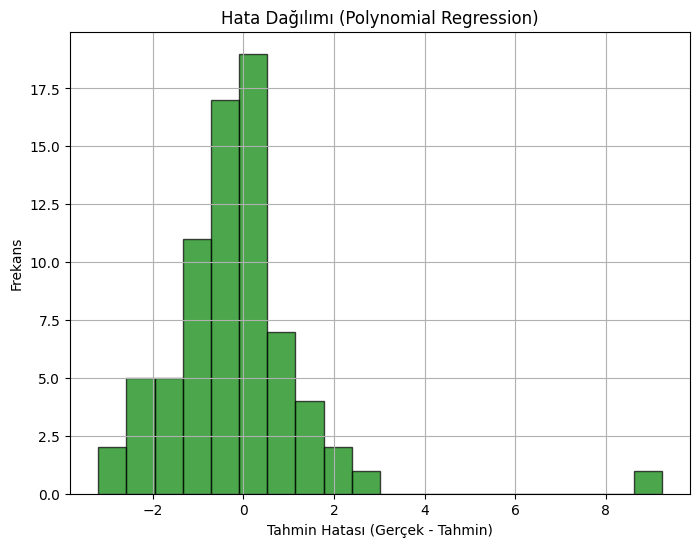

In [118]:
# PR Hata Dağılımı Grafiği
errors_pr = y_test.values - y_pred_pr.ravel()
plt.figure(figsize=(8, 6))
plt.hist(errors_pr, bins=20, color='green', edgecolor='k', alpha=0.7)
plt.title("Hata Dağılımı (Polynomial Regression)")
plt.xlabel("Tahmin Hatası (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()


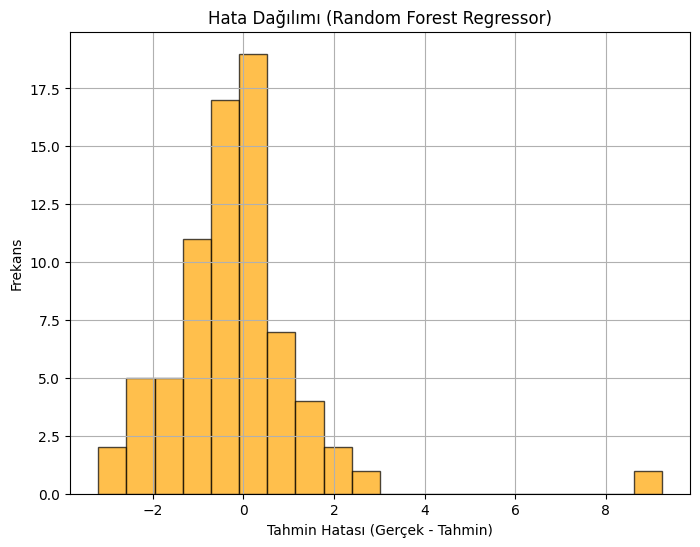

In [119]:
#RFR hata dağılım grafiği 
errors_rfr = y_test.values - y_pred_rfr.ravel()  # Gerçek değerler - Tahmin edilen değerler

plt.figure(figsize=(8, 6))
plt.hist(errors_rfr, bins=20, color='orange', edgecolor='k', alpha=0.7)
plt.title("Hata Dağılımı (Random Forest Regressor)")
plt.xlabel("Tahmin Hatası (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()

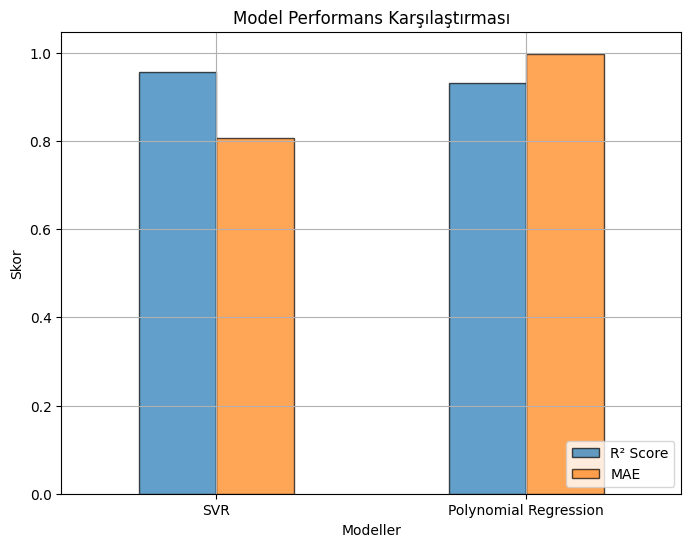

In [120]:
# PR SVR karşılaştırması Performans Karşılaştırma Grafiği
results_df.set_index('Model').plot(kind='bar', figsize=(8, 6), edgecolor='k', alpha=0.7)
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Modeller")
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()